# 0.0 Imports

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import math
import datetime

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from pycorrcat.pycorrcat import corr_matrix
from tabulate import tabulate
from IPython.core.display import HTML
from IPython.display import Image
from boruta import BorutaPy

## 0.1 Helper functions

In [2]:
%matplotlib inline
%pylab inline
plt.style.use( "bmh" )
plt.rcParams["figure.figsize"] = [25, 12]
plt.rcParams["font.size"] = 24
#display(HTML( "<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option( "display.expand_frame_repr", False )
sns.set()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory=False)
df_store_raw = pd.read_csv("data/store.csv", low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [5]:
old_columns = ["Store", "DayOfWeek", "Date", "Sales", "Customers", "Open", "Promo",
       "StateHoliday", "SchoolHoliday", "StoreType", "Assortment",
       "CompetitionDistance", "CompetitionOpenSinceMonth",
       "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek",
       "Promo2SinceYear", "PromoInterval"]

snake_case = lambda x: inflection.underscore(x)
new_columns = list(map(snake_case, old_columns))

# rename
df1.columns = new_columns

## 1.2 Data Dimensions

In [6]:
print(f"Number of rows: {df1.shape[0]}")
print(f"Number of columns: {df1.shape[1]}")

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [7]:
df1["date"] = pd.to_datetime(df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [9]:
# competition_distance    
df1["competition_distance"] = df1["competition_distance"].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1["competition_open_since_month"] = df1.apply(lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1)

# competition_open_since_year 
df1["competition_open_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"], axis=1)
                     
# promo2_since_week           
df1["promo2_since_week"] = df1.apply(lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"], axis=1)

# promo2_since_year           
df1["promo2_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"], axis=1)

# promo_interval
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"}

df1["promo_interval"].fillna(0, inplace=True)

df1["month_map"] = df1["date"].dt.month.map(month_map)

df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis=1)


## 1.6 Change Types

In [10]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)

df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)


## 1.7 Descriptive Statistical

In [11]:
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

### 1.7.1 Numerical Attributes

In [12]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/Users/joaooliveira/Documents/Projetos/data-science/RossmannSales/.RossmannSales/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

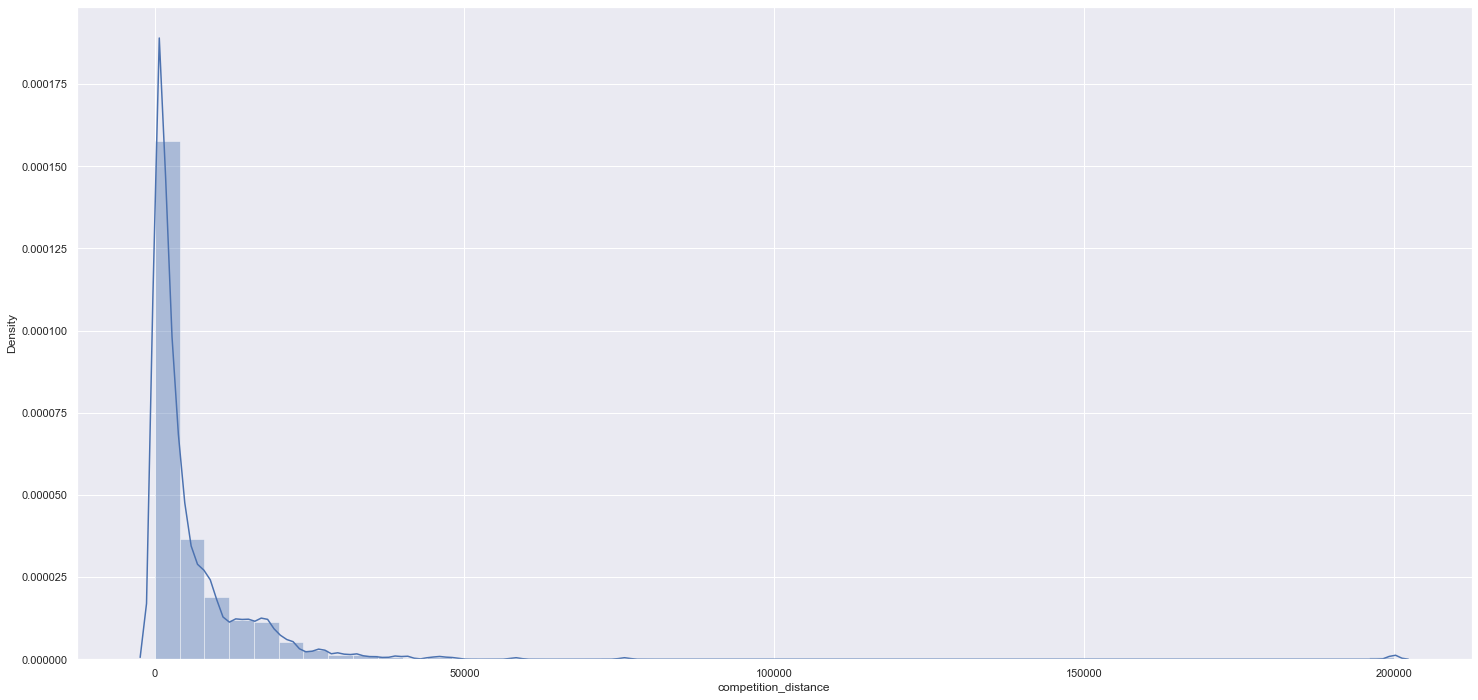

In [13]:
sns.distplot(df1["competition_distance"])

### 1.7.2 Categorical Attributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

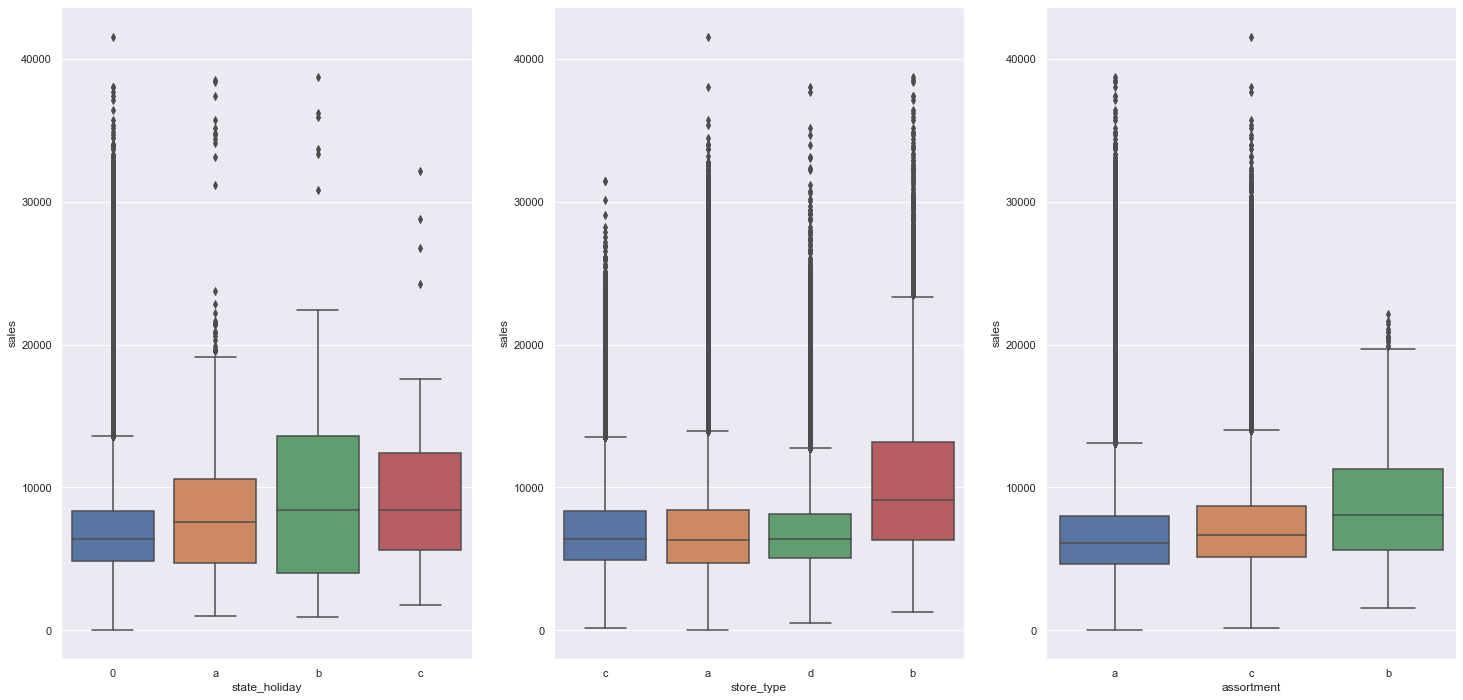

In [15]:
aux1 = df1[(df1["state_holiday"] != 0) & (df1["sales"] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x="assortment", y="sales", data=aux1)

# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

## 2.1 Mind map hypothesis

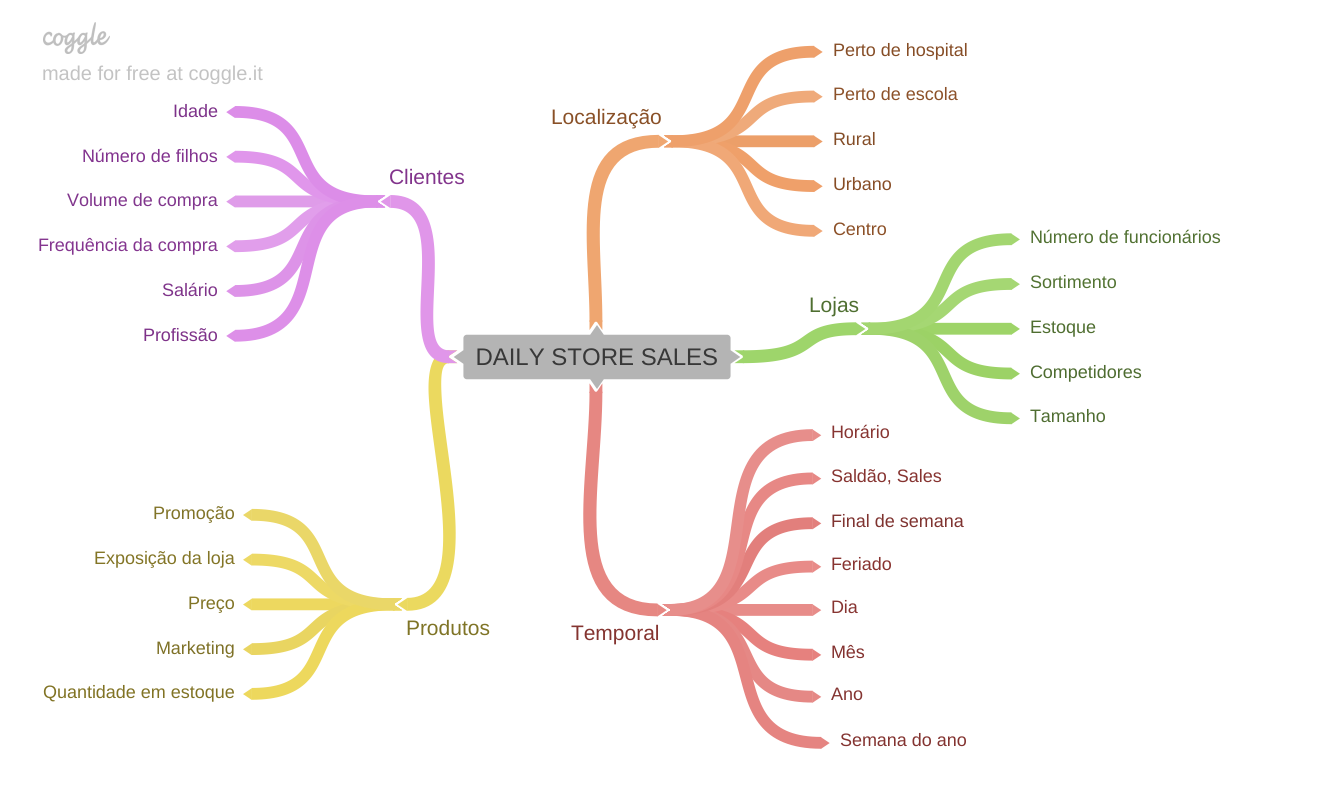

In [17]:
Image("img/MindMapHypothesis.png")

## 2.2 Creation of hypotheses

### 2.2.1 Store hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Product hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Time hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Final hypothesis list

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [18]:
# year
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
df2["week_of_year"] = df2["date"].dt.weekofyear

# year week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")

#  competition since
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year = x["competition_open_since_year"], month = x["competition_open_since_month"], day = 1), axis = 1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2["promo_since"] = df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)
df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w") - datetime.timedelta(days = 7))
df2["promo_time_week"] = ((df2["date"] - df2["promo_since"]) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2["assortment"] = df2["assortment"].apply(lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended")
# state holiday
df2["state_holiday"] = df2["state_holiday"].apply(lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day")


/var/folders/03/59j6j8ps3l3cykhbm5dm_nxh0000gn/T/ipykernel_733/3608850353.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2["week_of_year"] = df2["date"].dt.weekofyear


# 3.0 Variables Filtering

In [19]:
df3 = df2.copy()

## 3.1 Line filtering

In [20]:
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2 Columns selected

In [21]:
cols_drop = ["customers", "open", "promo_interval", "month_map"]
df3 = df3.drop(cols_drop, axis = 1)

In [22]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


# 4.0 Exploratory Data Analysis

In [23]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

/Users/joaooliveira/Documents/Projetos/data-science/RossmannSales/.RossmannSales/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


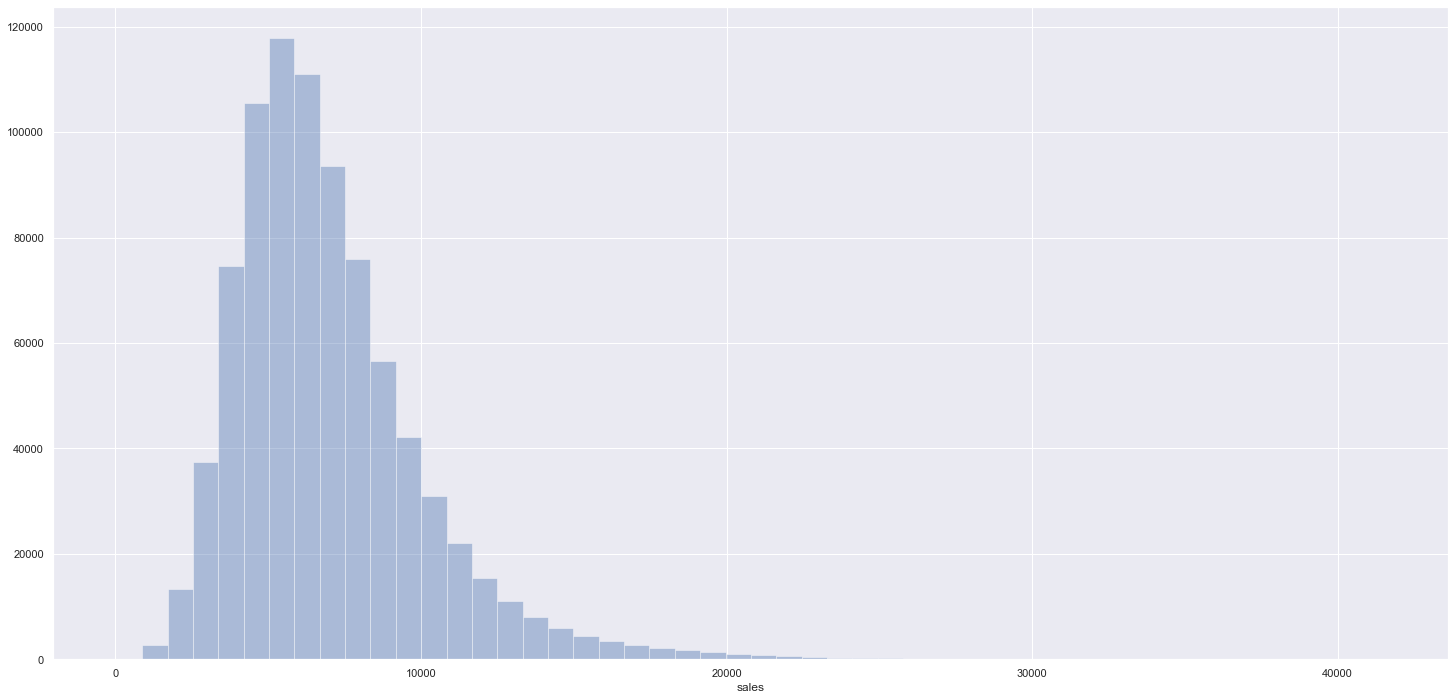

In [24]:
sns.distplot(df4["sales"], kde=False);

### 4.1.2 Variáveis numéricas

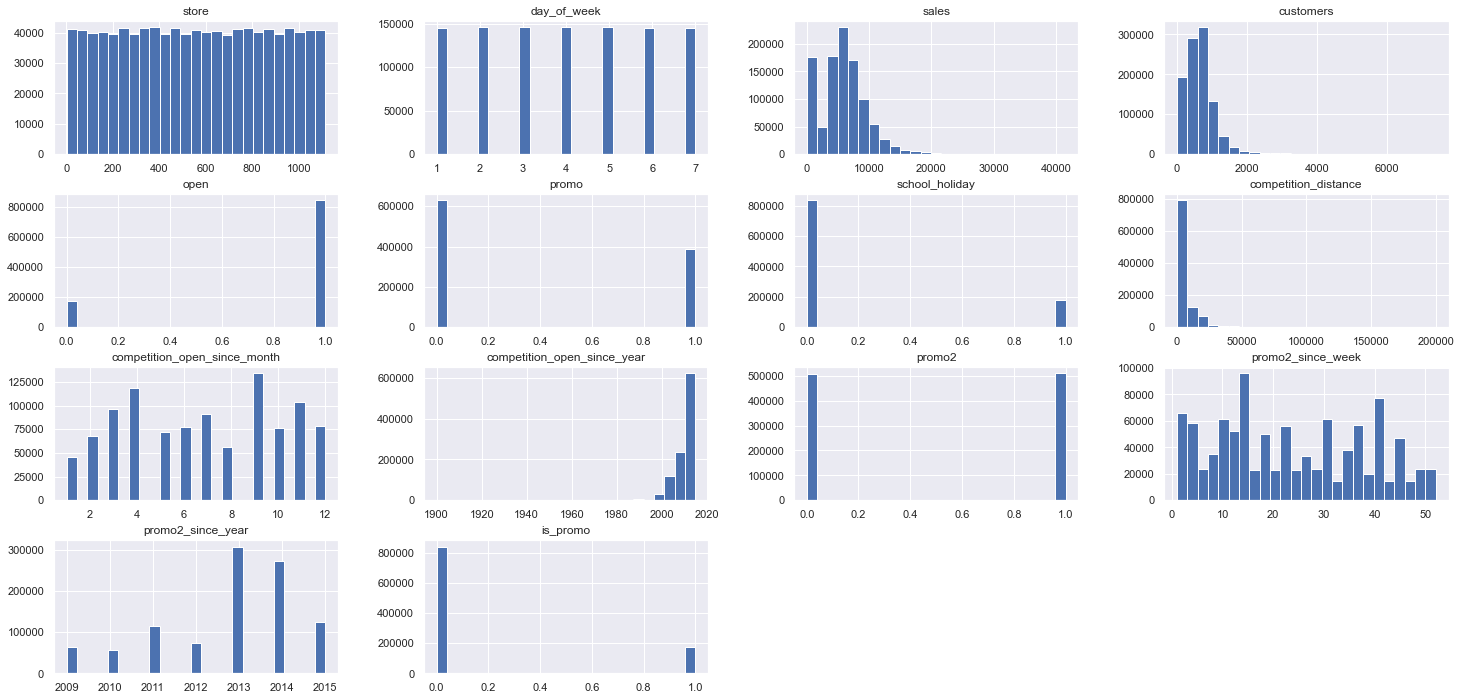

In [25]:
num_attributes.hist(bins=25);

### 4.1.3 Variáveis categóricas

/Users/joaooliveira/Documents/Projetos/data-science/RossmannSales/.RossmannSales/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/joaooliveira/Documents/Projetos/data-science/RossmannSales/.RossmannSales/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/joaooliveira/Documents/Projetos/data-science/RossmannSales/.RossmannSales/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the

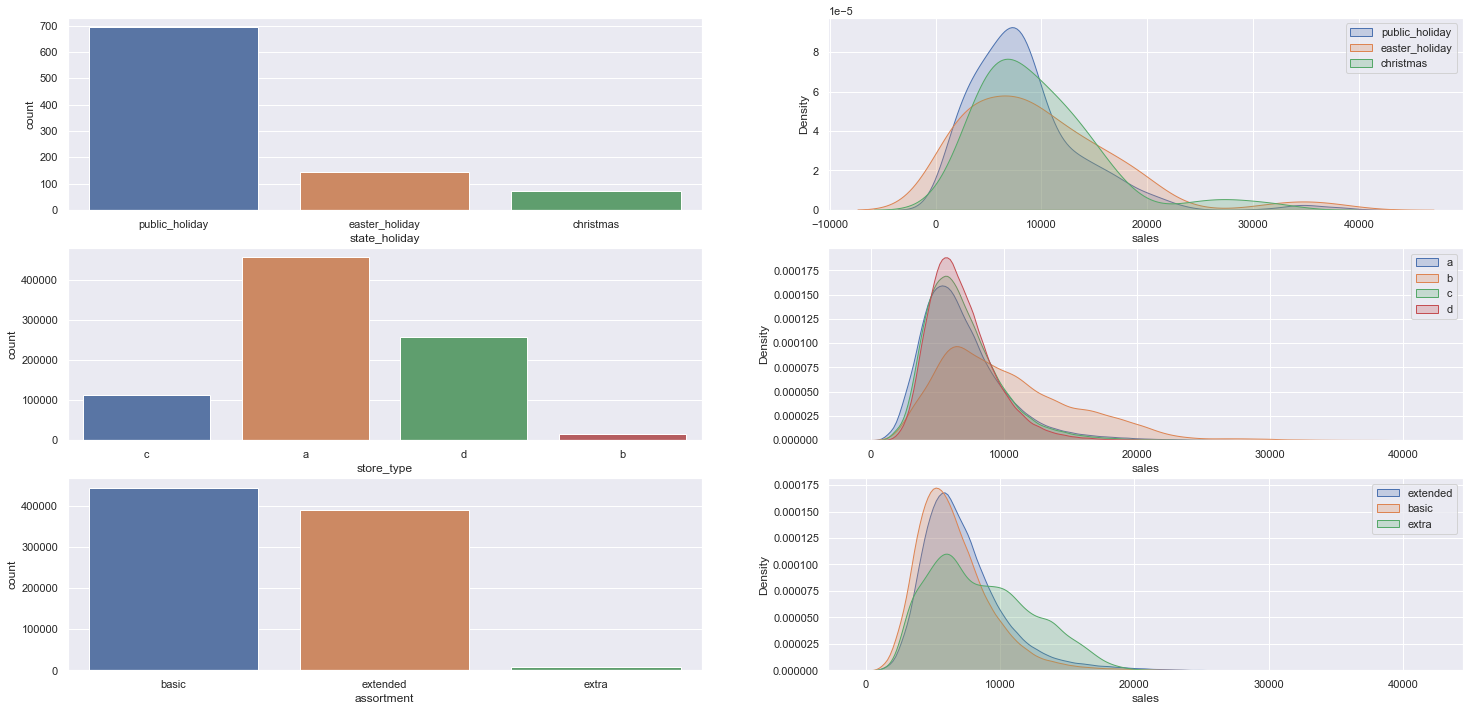

In [26]:
#state holiday
plt.subplot(3, 2, 1)
sh = df4[df4["state_holiday"] != "regular_day"]
sns.countplot(sh["state_holiday"])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4["state_holiday"] == "public_holiday"]["sales"], label="public_holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="easter_holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "christmas"]["sales"], label="christmas", shade=True)
plt.legend()

# store type
plt.subplot(3, 2, 3)
sns.countplot(df4["store_type"])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4["store_type"] == "a"]["sales"], label="a", shade=True)
sns.kdeplot(df4[df4["store_type"] == "b"]["sales"], label="b", shade=True)
sns.kdeplot(df4[df4["store_type"] == "c"]["sales"], label="c", shade=True)
sns.kdeplot(df4[df4["store_type"] == "d"]["sales"], label="d", shade=True)
plt.legend()

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4["assortment"])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4["assortment"] == "extended"]["sales"], label="extended", shade=True)
sns.kdeplot(df4[df4["assortment"] == "basic"]["sales"], label="basic", shade=True)
sns.kdeplot(df4[df4["assortment"] == "extra"]["sales"], label="extra", shade=True)
plt.legend()

## 4.2 Análise Bivariada

**H1. Lojas com maior sortimento deveriam vender mais.**

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

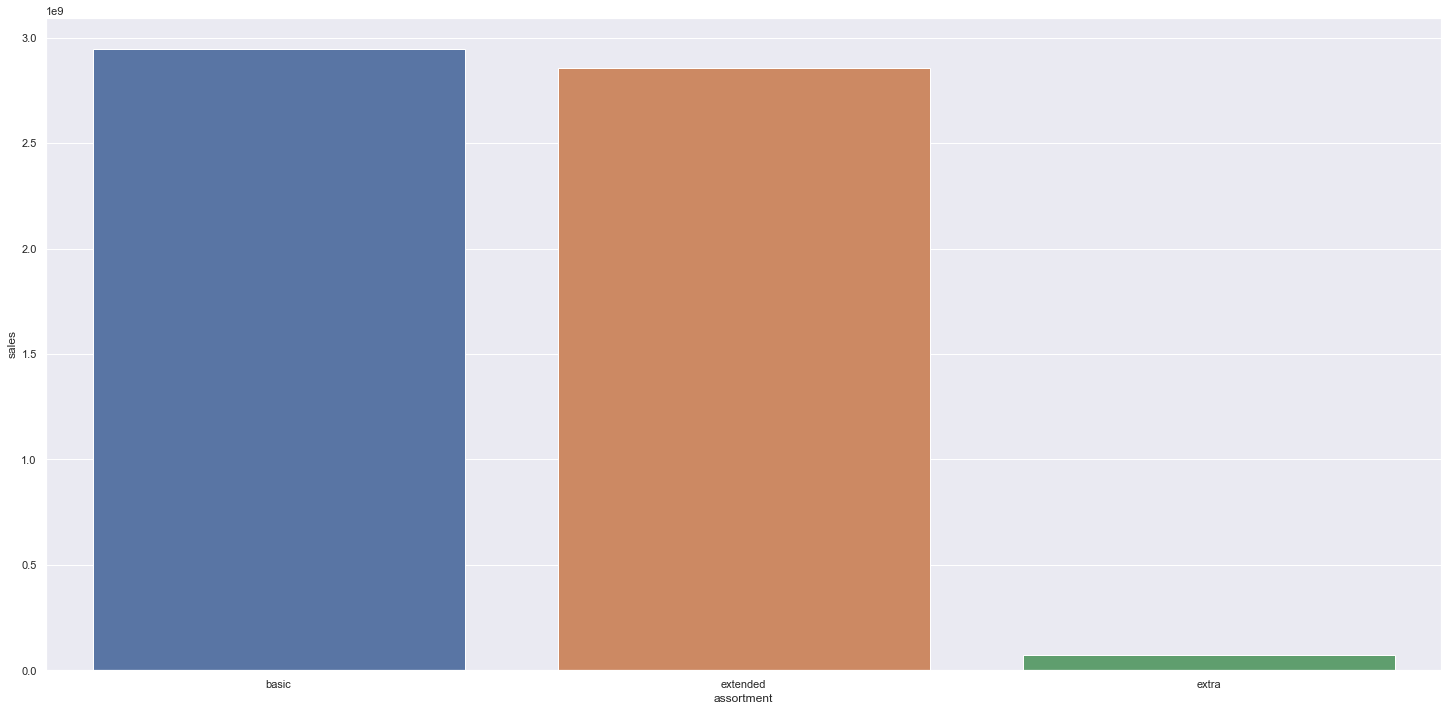

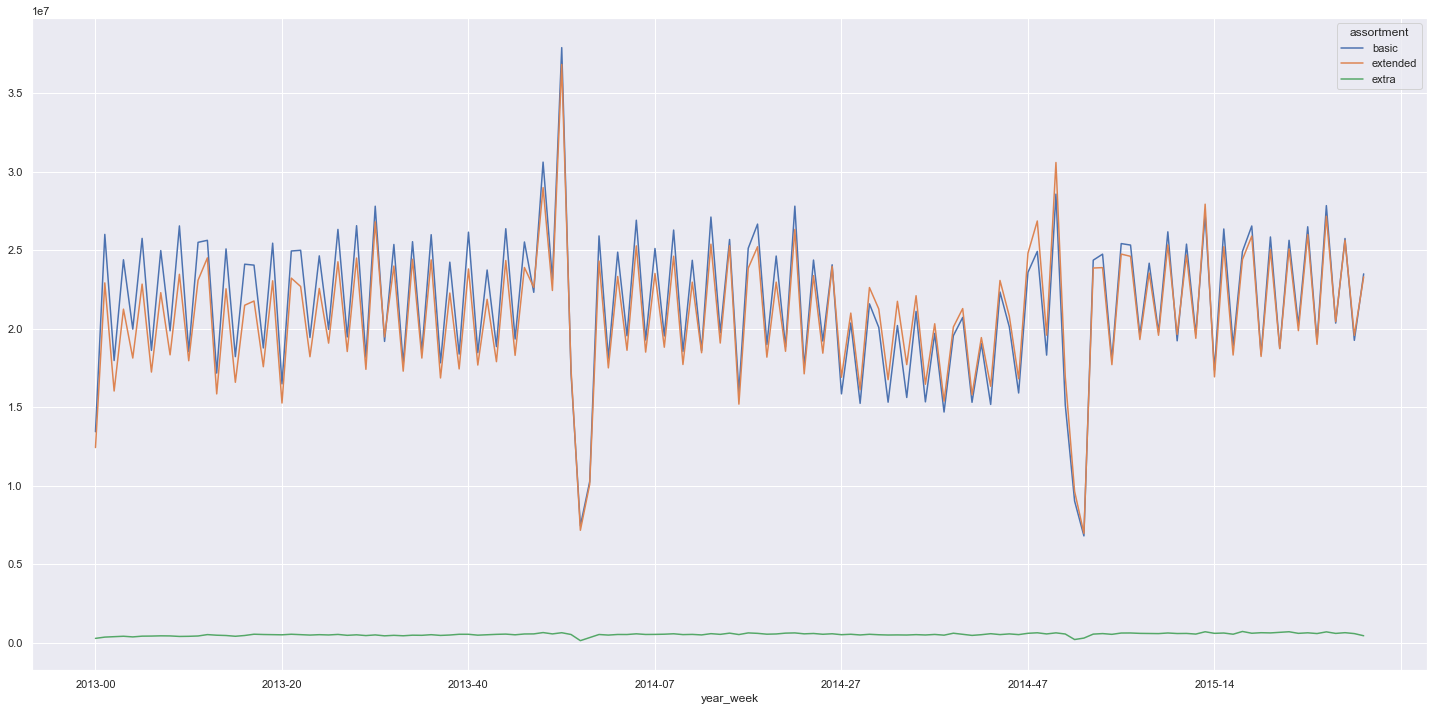

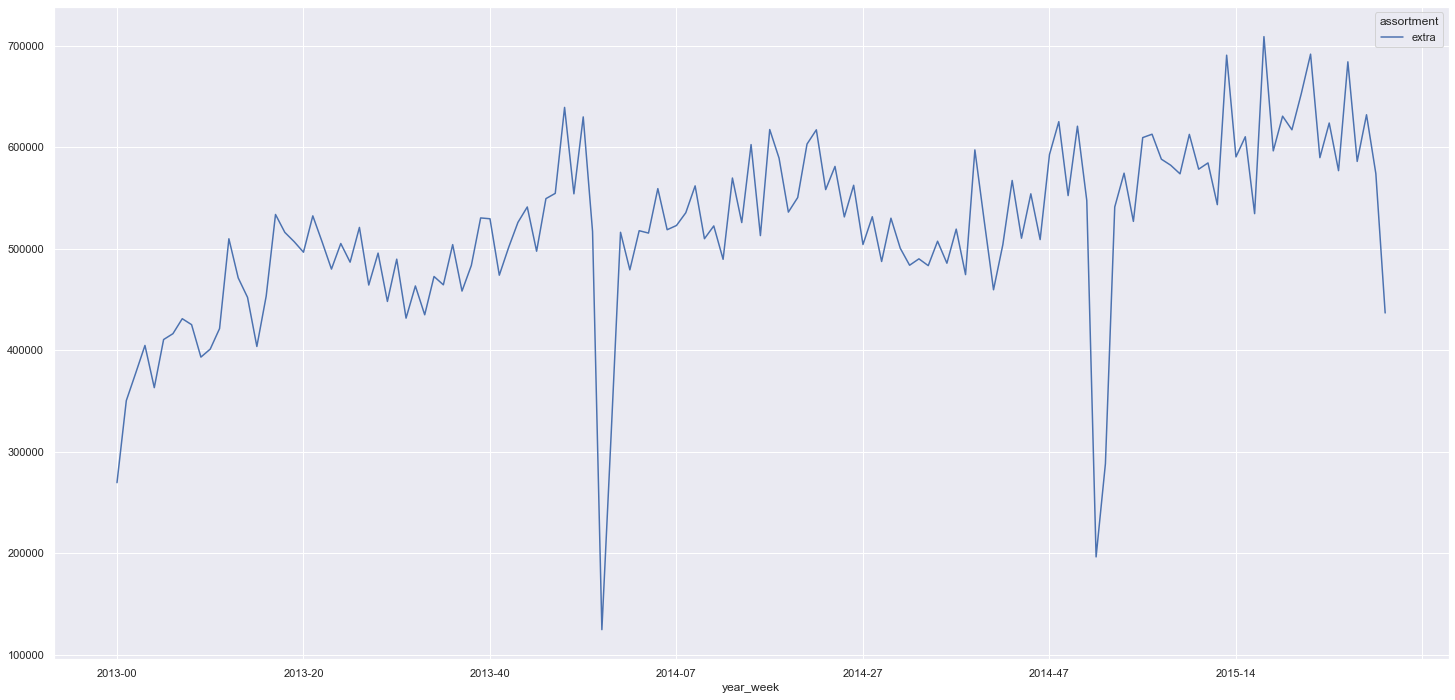

In [27]:
aux1 = df4[["assortment", "sales"]].groupby("assortment").sum().reset_index()
sns.barplot( x="assortment", y="sales", data=aux1 );

aux2 = df4[["year_week", "assortment", "sales"]].groupby(["year_week", "assortment"]).sum().reset_index()
aux2.pivot(index="year_week", columns="assortment", values="sales").plot()

aux3 = aux2[aux2["assortment"] == "extra"]
aux3.pivot(index="year_week", columns="assortment", values="sales").plot()

**H2. Lojas com competidores mais próximos deveriam vender menos.**

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

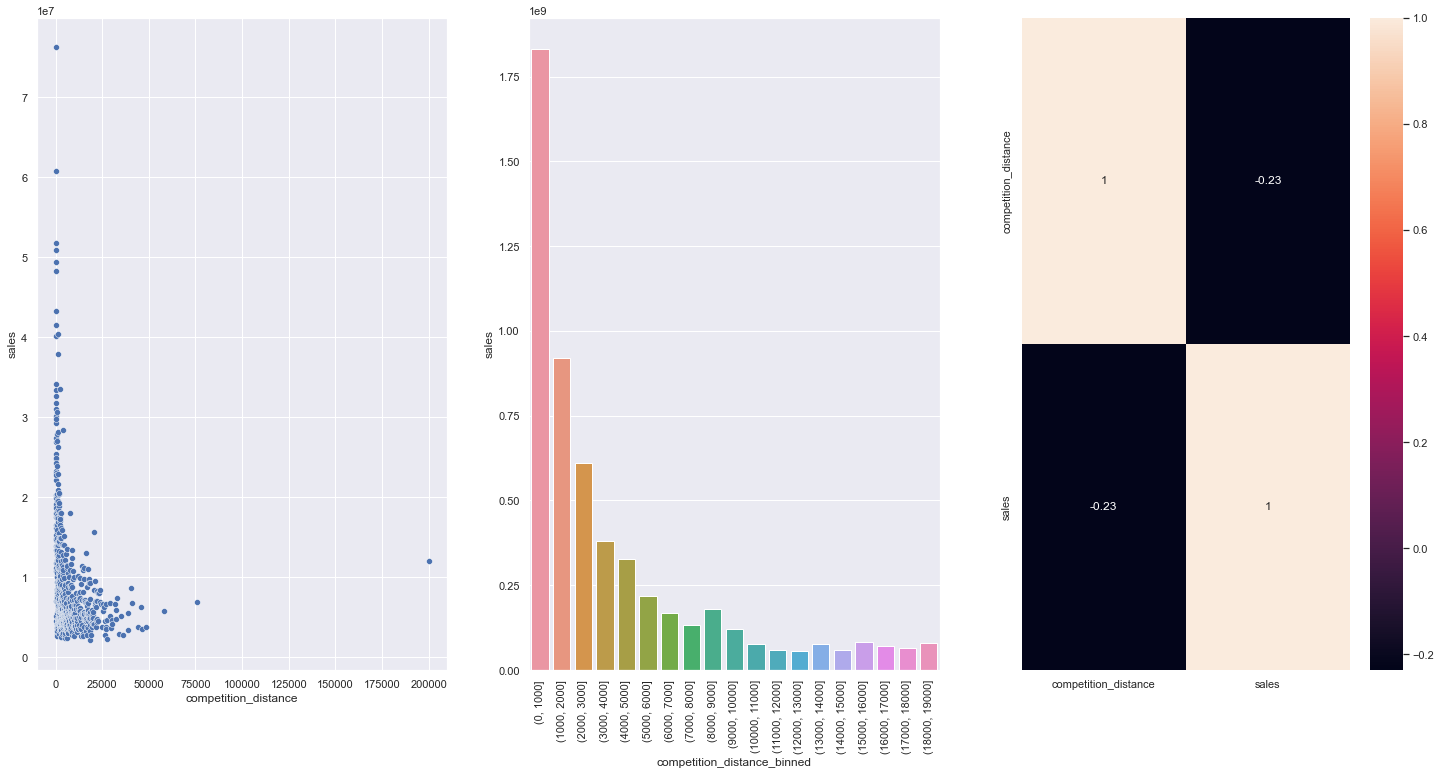

In [28]:
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x ="competition_distance", y="sales", data=aux1);

plt.subplot( 1, 3, 2 )
bins = list(np.arange(0, 20000, 1000))
aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins)
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").sum().reset_index()
sns.barplot(x="competition_distance_binned", y="sales", data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method="pearson"), annot=True);

**H3. Lojas com competidores A mais tempo deveriam vendem mais.**

**FALSE** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

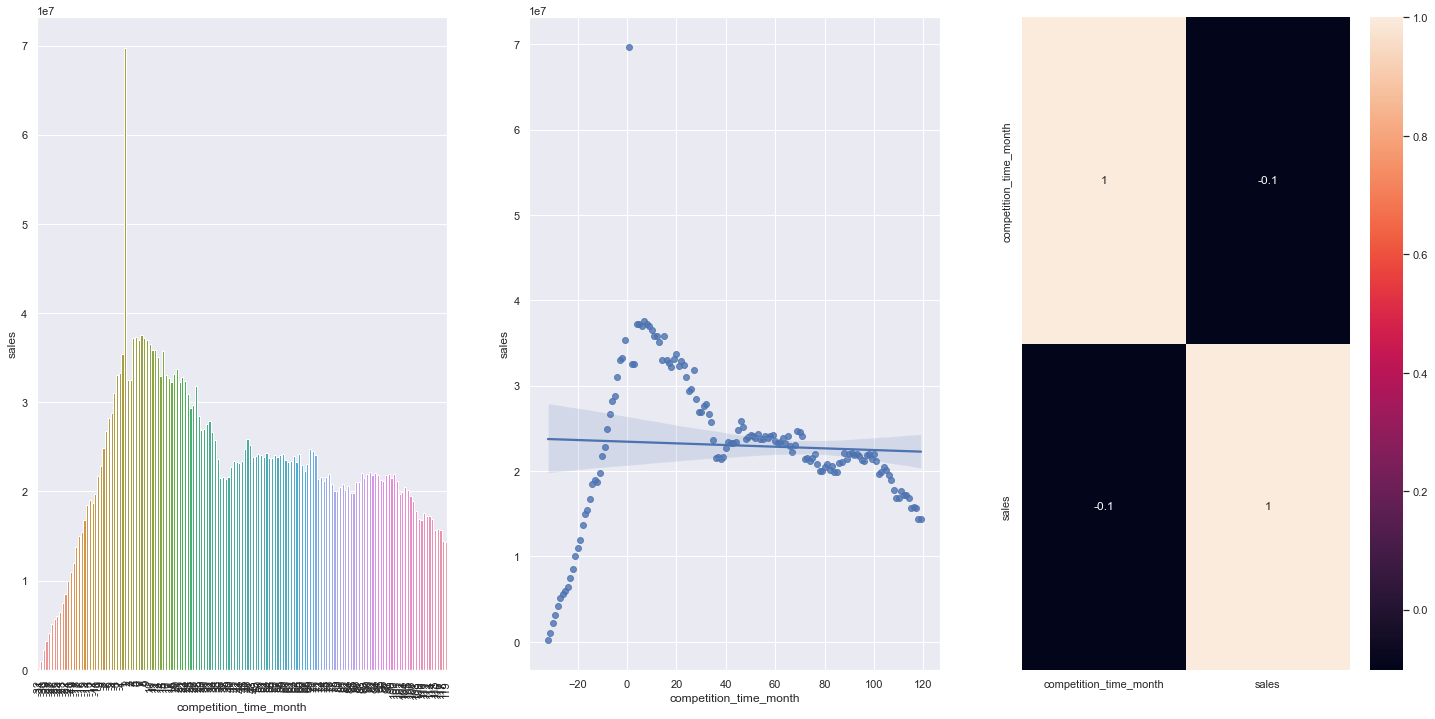

In [29]:
plt.subplot( 1, 3, 1 )
aux1 = df4[["competition_time_month", "sales"]].groupby("competition_time_month").sum().reset_index()
aux2 = aux1[(aux1["competition_time_month"] < 120) & (aux1["competition_time_month"] != 0)]
sns.barplot(x="competition_time_month", y="sales", data=aux2);
plt.xticks( rotation=90 );

plt.subplot(1, 3, 2)
sns.regplot(x="competition_time_month", y="sales", data=aux2);
plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method="pearson"), annot=True);

**H4. Lojas com promoções ativas por mais tempo deveriam vender mais.**

**FALSA** Lojas com promocoes ativas por mais tempo vendem menos após um certo período de promocao


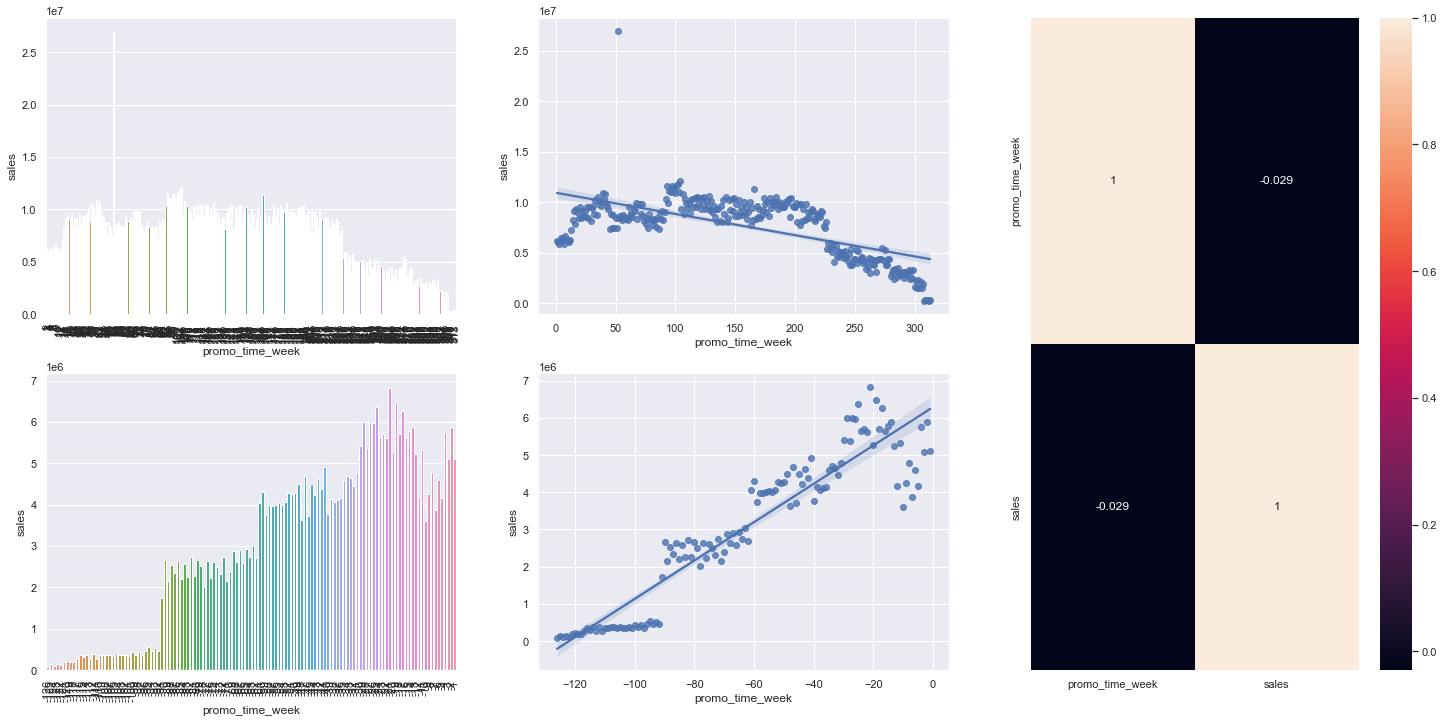

In [30]:
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1["promo_time_week"] > 0] # promo extendido
sns.barplot(x="promo_time_week", y="sales", data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(x="promo_time_week", y="sales", data=aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1["promo_time_week"] < 0] # promo regular
sns.barplot(x="promo_time_week", y="sales", data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(x="promo_time_week", y="sales", data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method="pearson"), annot=True);

**H5. Lojas com mais dias de promoção deveriam vender mais**

**H6. Lojas com mais promoções consecutivas deveriam vender mais.**

**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [31]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


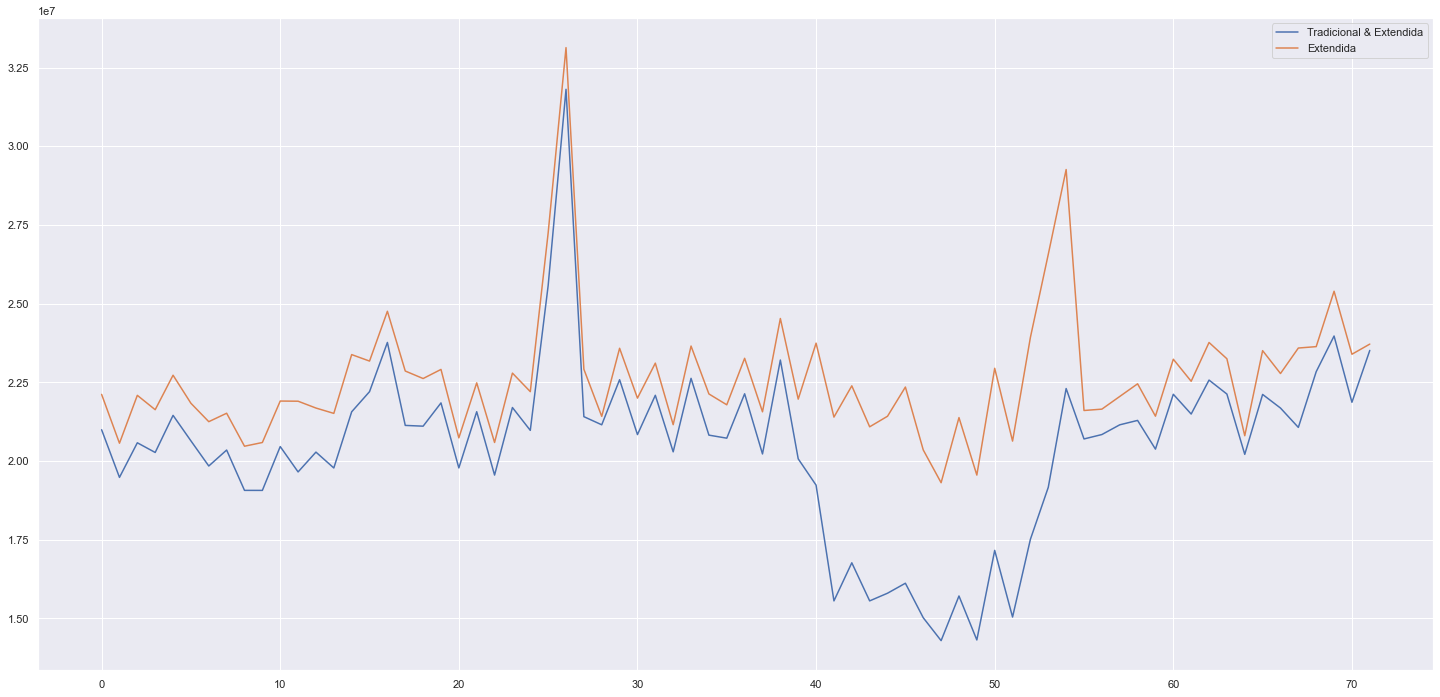

In [32]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

**H7. Lojas abertas durante o feriado de Natal deveriam vender mais.**

**FALSA** Lojas abertas durante o feriado do Natal vendem menos

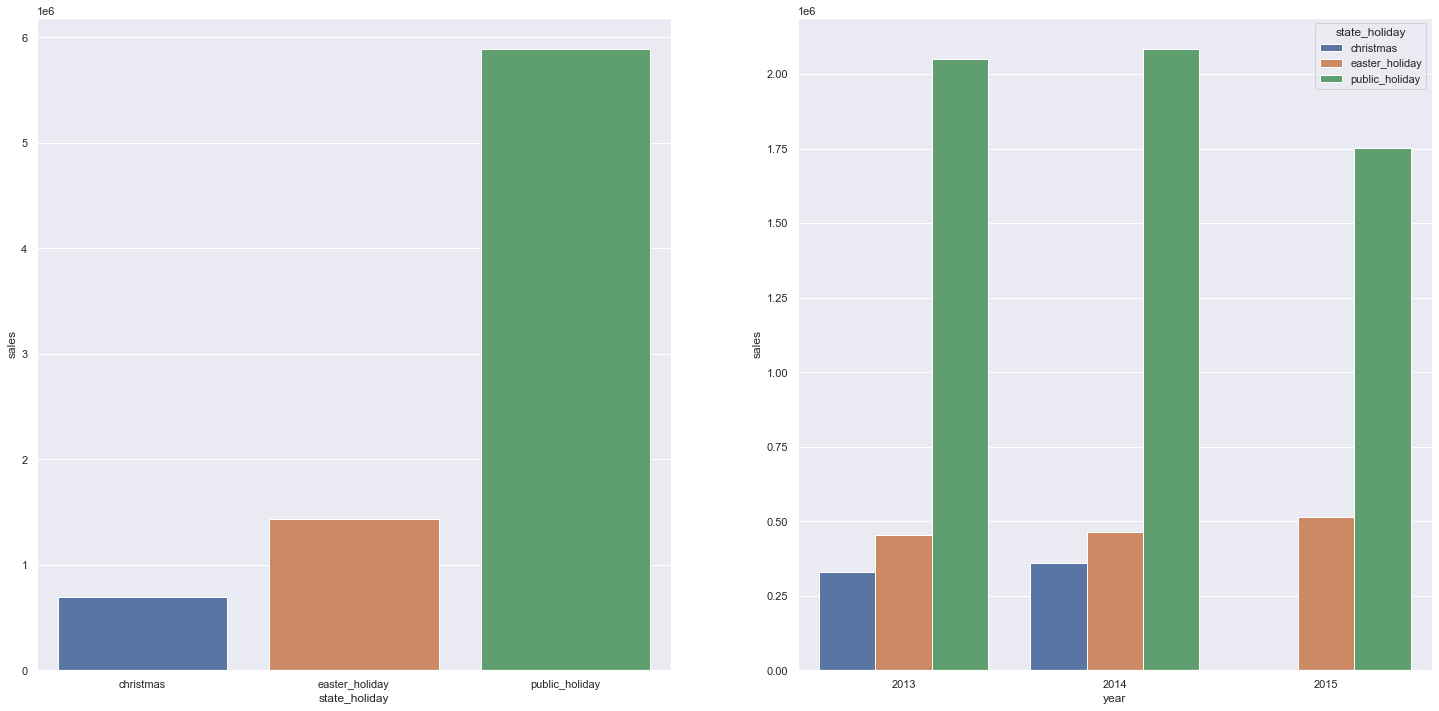

In [33]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

**H8. Lojas deveriam vender mais ao longo dos anos.**

**FALSA** Lojas vendem menos ao longo dos anos

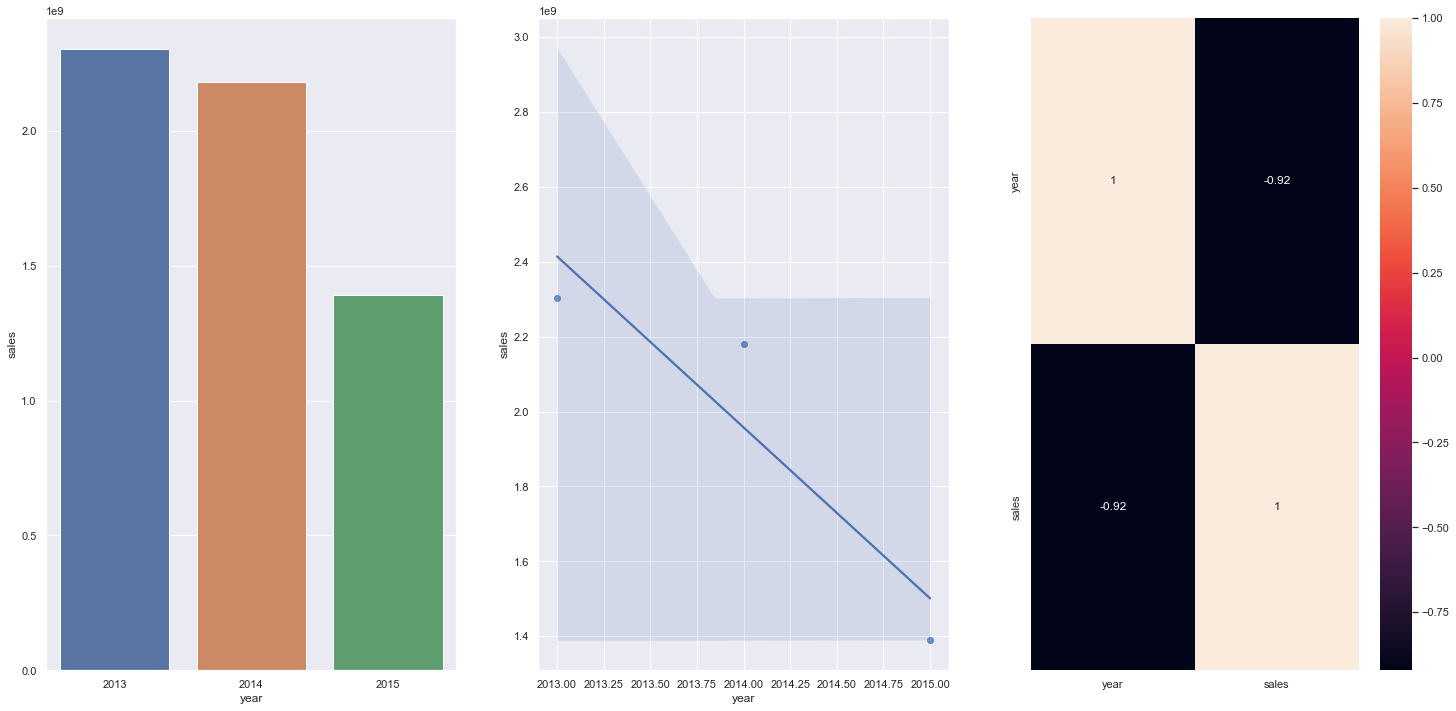

In [34]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H9. Lojas deveriam vender mais no segundo semestre do ano.**

**FALSA** Lojas vendem menos no segundo semestre do ano

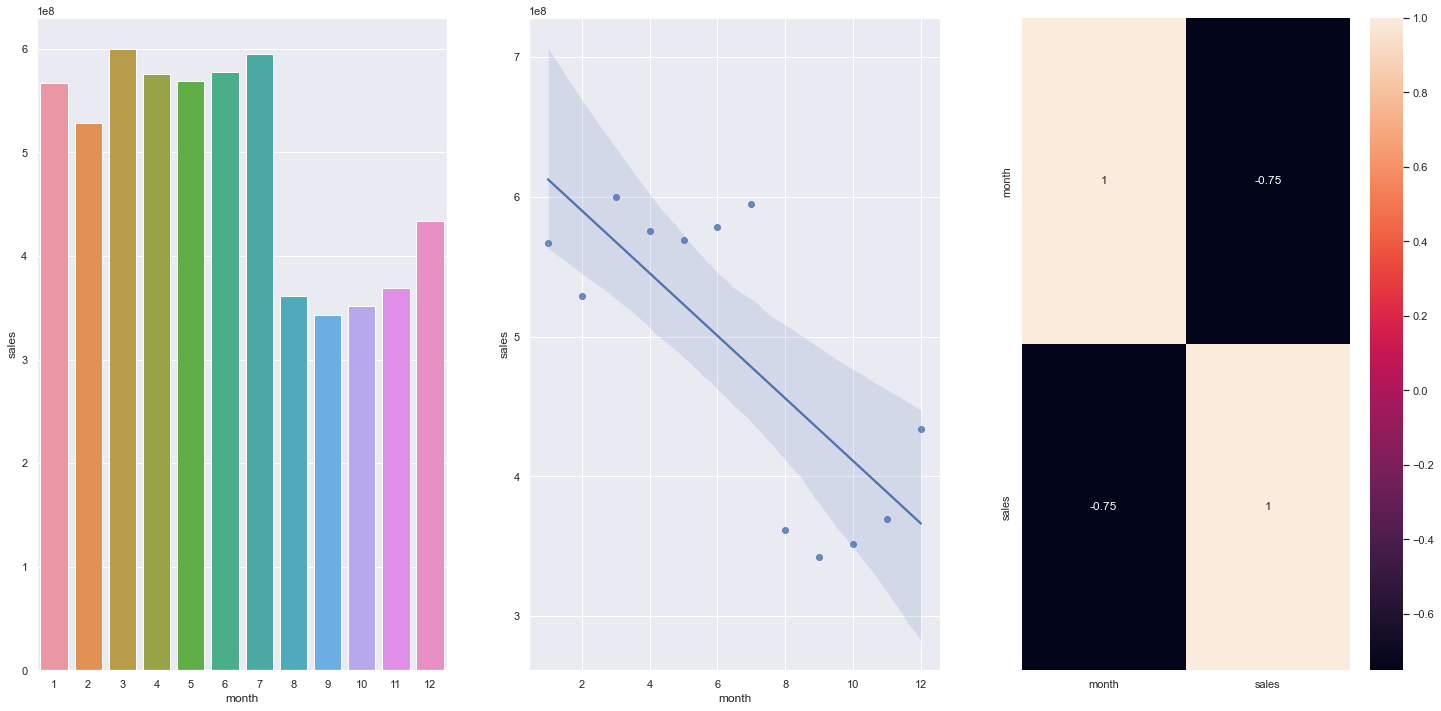

In [35]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H10. Lojas deveriam vender mais depois do dia 10 de cada mês.**

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

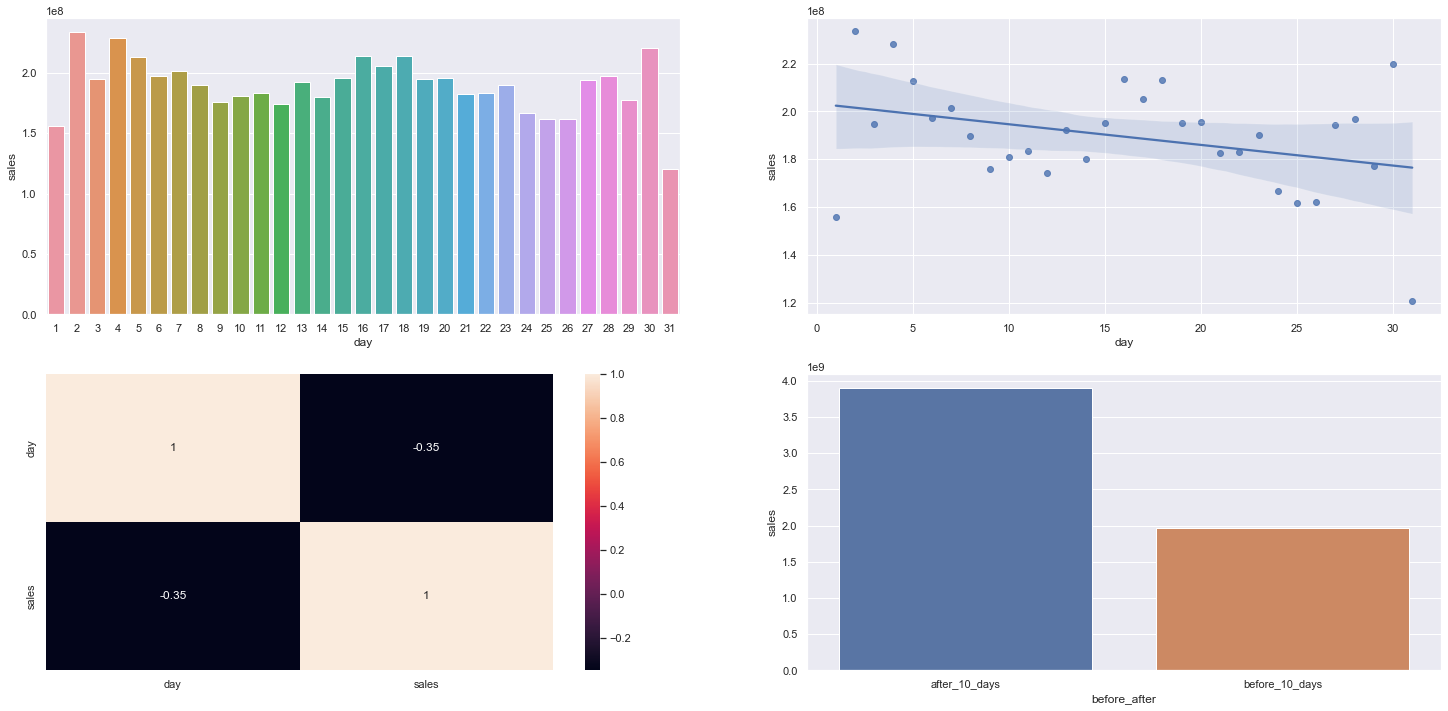

In [36]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

**H11. Lojas deveriam vender menos aos finais de semana.**

**VERDADEIRA** Lojas vendem menos nos final de semana

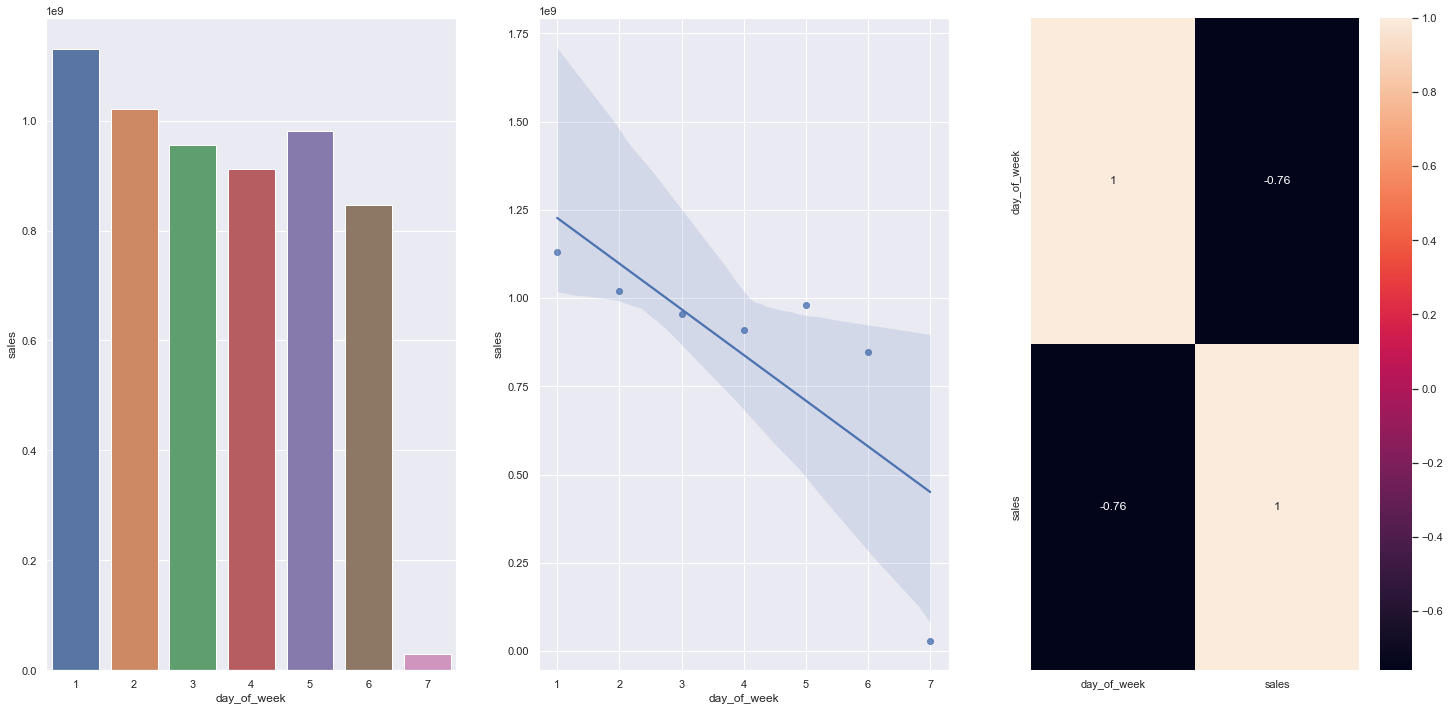

In [37]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H12. Lojas deveriam vender menos durante os feriados escolares.**

**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto nos meses de Julho e Agosto.

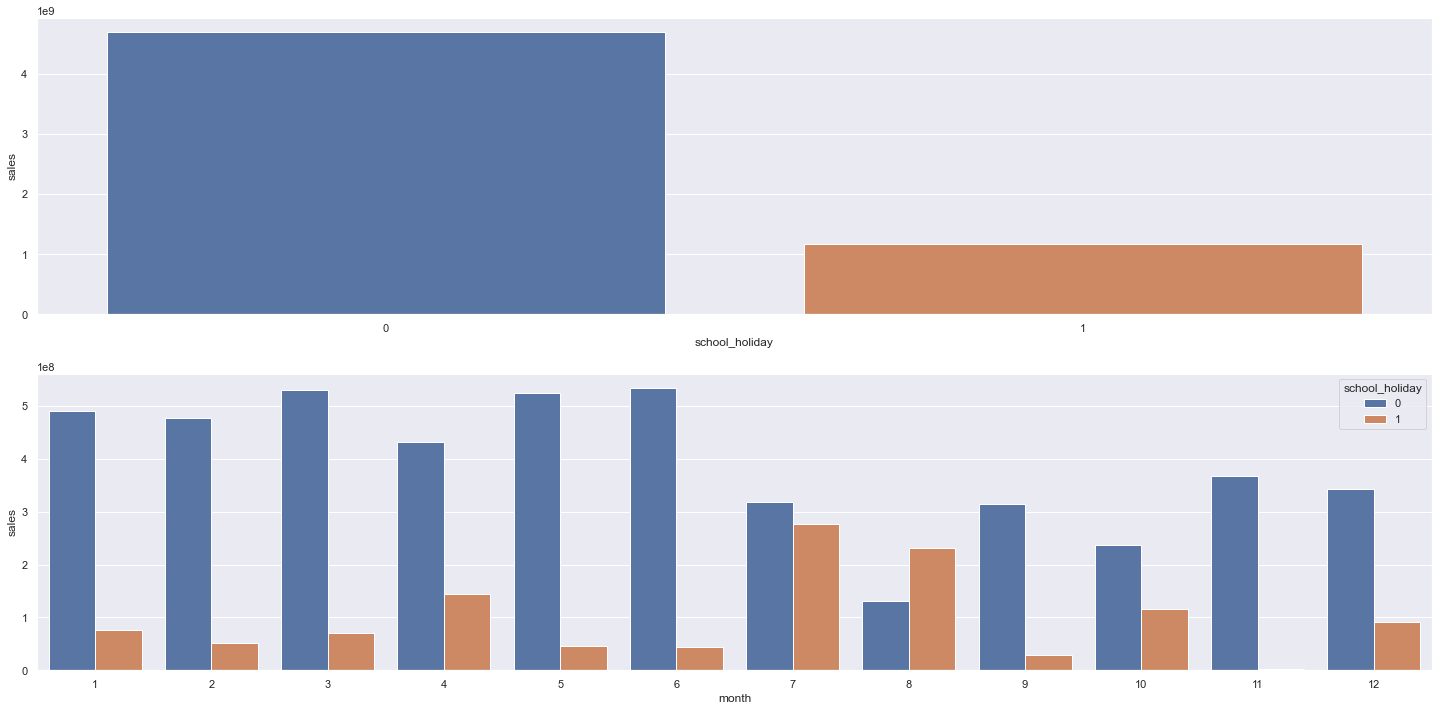

In [38]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das Hipóteses

In [39]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Atributos numéricos

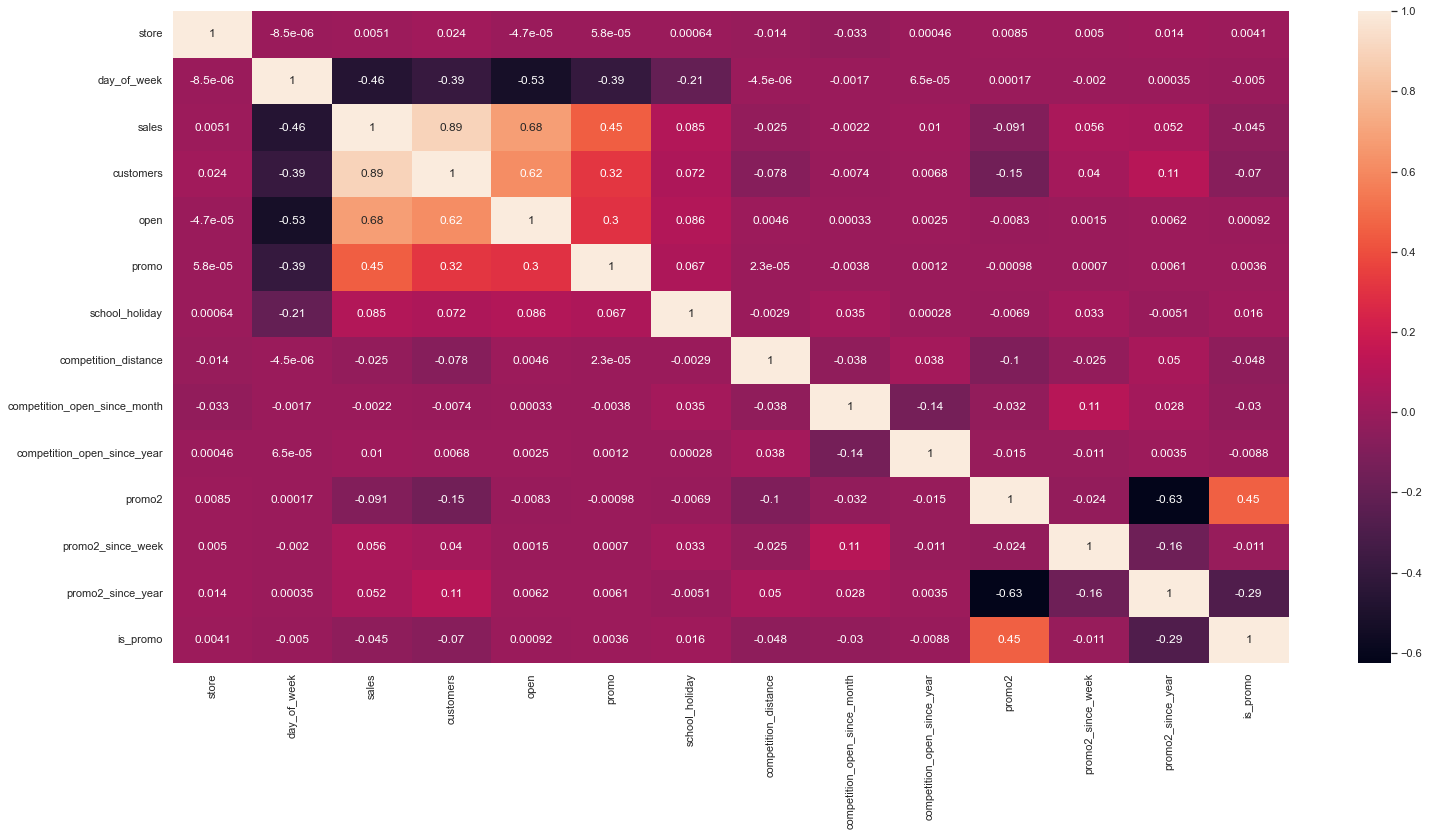

In [40]:
correlation = num_attributes.corr(method="pearson")
sns.heatmap(correlation, annot=True);

### 4.3.2 Atributos categóricos

In [41]:
a = df4.select_dtypes(include="object")
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


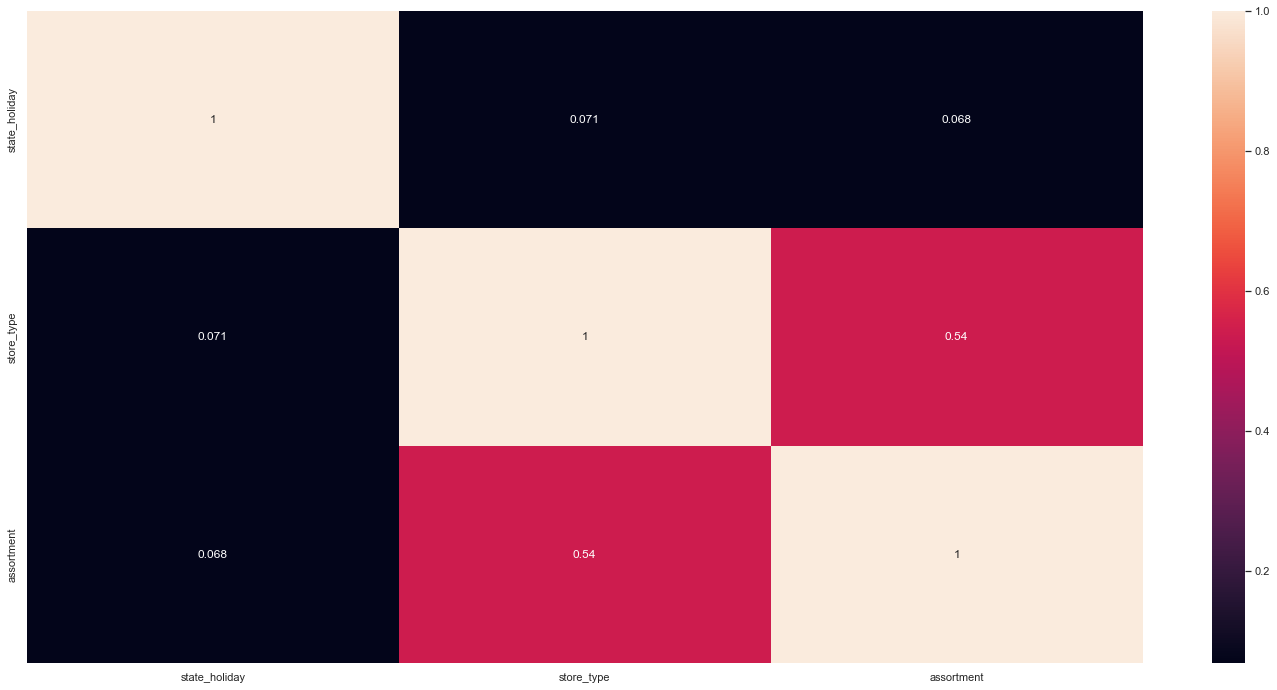

In [42]:
# Cramer V
cm = corr_matrix(a, ["state_holiday", "store_type", "assortment"])
sns.heatmap(cm, annot=True);

# 5.0 Data Preparation

In [43]:
df5 = df4.copy()

## 5.1 Normalizacão

## 5.2 Reescala

In [44]:
mms = preprocessing.MinMaxScaler()
rs = preprocessing.RobustScaler()

# competition_distance - rs
df5["competition_distance"] = rs.fit_transform(df5[["competition_distance"]].values)

# year - mms
df5["year"] = mms.fit_transform(df5[["year"]].values)

# competition time month - rs
df5["competition_time_month"] = rs.fit_transform(df5[["competition_time_month"]].values)

# promo time week - mms
df5["promo_time_week"] = mms.fit_transform(df5[["promo_time_week"]].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [45]:
# state_holiday
df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns=["state_holiday"])

# store_type
le = preprocessing.LabelEncoder()
df5["store_type"] = le.fit_transform(df5["store_type"])

# assortment
assortment_dict = {"basic": 1, "extra": 2, "extended": 3}
df5["assortment"] = df5["assortment"].map(assortment_dict)

### 5.3.2 Nature Transformation

In [46]:
# day of week
df5["day_of_week_sin"] = df5["day_of_week"].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5["day_of_week_cos"] = df5["day_of_week"].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

# month
df5["month_sin"] = df5["month"].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5["month_cos"] = df5["month"].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# day
df5["day_sin"] = df5["day"].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5["day_cos"] = df5["day"].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# week of year
df5["week_of_year_sin"] = df5["week_of_year"].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5["week_of_year_cos"] = df5["week_of_year"].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

In [47]:
df5.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
378584,101,5,2014-08-01,9239,1,1,3,3,0.017742,8,2014,1,22,2012,0,0.5,8,1,31,2014-30,2014-08-01,-0.216216,2012-05-21,0.546697,0,0,0,1,-0.974928,-0.222521,-0.866025,-0.500000,0.207912,0.978148,-0.568065,-0.822984
545284,835,5,2014-02-28,5899,0,0,0,1,0.090323,12,2007,1,10,2014,0,0.5,2,28,9,2014-08,2007-12-01,0.810811,2014-03-03,0.284738,0,0,0,1,-0.974928,-0.222521,0.866025,0.500000,-0.406737,0.913545,0.885456,0.464723
293696,339,5,2014-10-31,5643,0,1,0,3,-0.008065,10,2014,1,10,2013,0,0.5,10,31,44,2014-43,2014-10-01,-0.202703,2013-03-04,0.482916,0,0,0,1,-0.974928,-0.222521,-0.866025,0.500000,0.207912,0.978148,-0.822984,0.568065
1002481,882,1,2013-01-14,8583,0,0,0,1,-0.370968,4,2013,0,3,2013,0,0.0,1,14,3,2013-02,2013-04-01,-0.256757,2013-01-14,0.287016,0,0,0,1,0.781831,0.623490,0.500000,0.866025,0.207912,-0.978148,0.354605,0.935016
766302,1083,3,2013-08-14,4931,1,1,3,3,1.485484,8,2013,1,5,2013,1,0.0,8,14,33,2013-32,2013-08-01,-0.216216,2013-01-28,0.350797,0,0,0,1,0.433884,-0.900969,-0.866025,-0.500000,0.207912,-0.978148,-0.748511,-0.663123


# 6.0 Feature Selection

In [49]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [52]:
cols_drop = ["month", "day", "week_of_year", "year_week", "day_of_week", "promo_since", "competition_since"]
df6 = df6.drop(cols_drop, axis=1)

In [53]:
df6[["store", "date"]].groupby("store").max().reset_index()["date"][0] - datetime.timedelta(days=6 * 7)

Timestamp('2015-06-19 00:00:00')

In [59]:
# training dataset
X_train = df6[df6["date"] < "2015-06-19"]
y_train = X_train["sales"]

# test dataset
X_test = df6[df6["date"] >= "2015-06-19"]
y_test = X_test["sales"]

## 6.2 Boruta as Feature Selector

In [75]:
## training and test dataset for Boruta Algorithm
#X_train_n = X_train.drop(["date", "sales"], axis=1).values
#y_train_n = y_train.values.ravel()
#
## RandomForestRegressor 
#rf = RandomForestRegressor(n_jobs=-1)
#
## define Boruta
#boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best features from Boruta

In [76]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop(["date", "sales"], axis=1)
#cols_selected_boruta = X_train.fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [79]:
cols_selected_boruta = [
    "store",
    "promo",
    "store_type",
    "assortment",
    "competition_distance",
    "competition_open_since_month",
    "competition_open_since_year",
    "promo2",
    "promo2_since_week",
    "promo2_since_year",
    "competition_time_month",
    "promo_time_week",
    "day_of_week_sin",
    "day_of_week_cos",
    "month_sin",
    "month_cos",
    "day_sin",
    "day_cos",
    "week_of_year_sin",
    "week_of_year_cos"
]

# columns to add
columns_to_add = ["date", "sales"]

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(columns_to_add)

In [81]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']